In [3]:
import os
import tarfile
import urllib
import pandas as pd

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

# Fungsi untuk mengunduh data
def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    os.makedirs(housing_path, exist_ok=True)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

# Fungsi untuk memuat data dari file CSV
def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

# Menjalankan fungsi
fetch_housing_data()
housing = load_housing_data()

   longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
0    -122.23     37.88                41.0        880.0           129.0   
1    -122.22     37.86                21.0       7099.0          1106.0   
2    -122.24     37.85                52.0       1467.0           190.0   
3    -122.25     37.85                52.0       1274.0           235.0   
4    -122.25     37.85                52.0       1627.0           280.0   

   population  households  median_income  median_house_value ocean_proximity  
0       322.0       126.0         8.3252            452600.0        NEAR BAY  
1      2401.0      1138.0         8.3014            358500.0        NEAR BAY  
2       496.0       177.0         7.2574            352100.0        NEAR BAY  
3       558.0       219.0         5.6431            341300.0        NEAR BAY  
4       565.0       259.0         3.8462            342200.0        NEAR BAY  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639

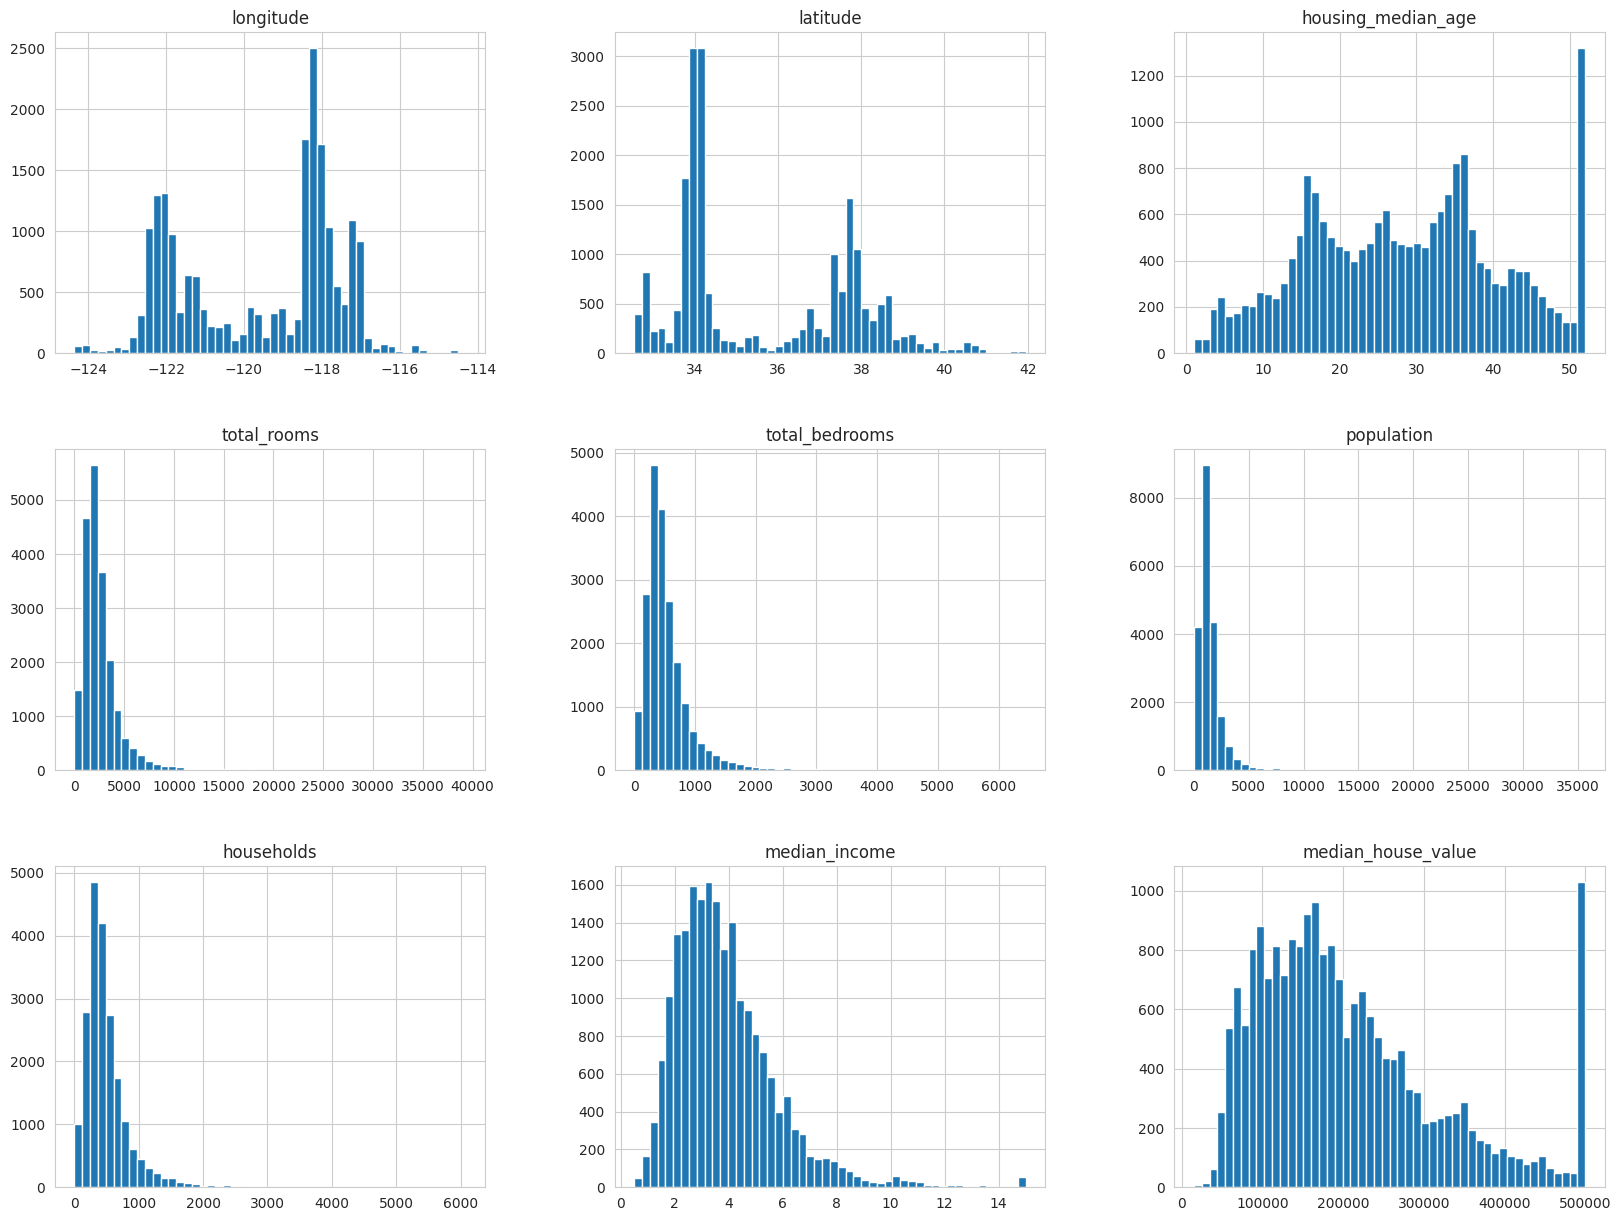

In [4]:
# Menampilkan 5 baris pertama
print(housing.head()) #

# Mendapatkan informasi ringkas, termasuk tipe data dan nilai null
print(housing.info()) #

# Melihat ringkasan statistik untuk atribut numerik
print(housing.describe()) #

# Membuat histogram untuk semua atribut numerik
import matplotlib.pyplot as plt
housing.hist(bins=50, figsize=(20,15)) #
plt.show()

In [5]:
from sklearn.model_selection import StratifiedShuffleSplit
import numpy as np

# Membuat kategori pendapatan
housing["income_cat"] = pd.cut(housing["median_income"],
                               bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
                               labels=[1, 2, 3, 4, 5]) #

# Membagi data menggunakan StratifiedShuffleSplit
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

# Menghapus atribut income_cat agar kembali ke keadaan semula
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True) #

# Membuat salinan training set untuk eksplorasi
housing = strat_train_set.copy() #

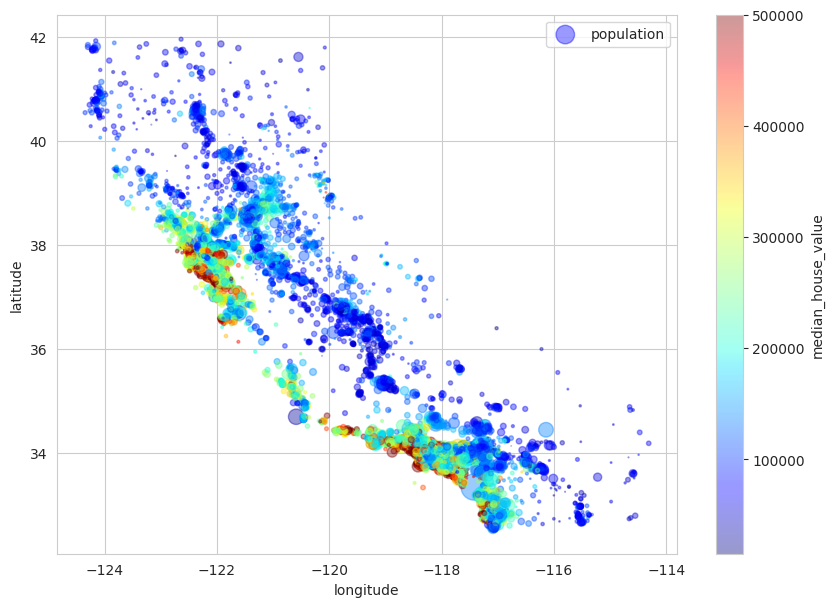

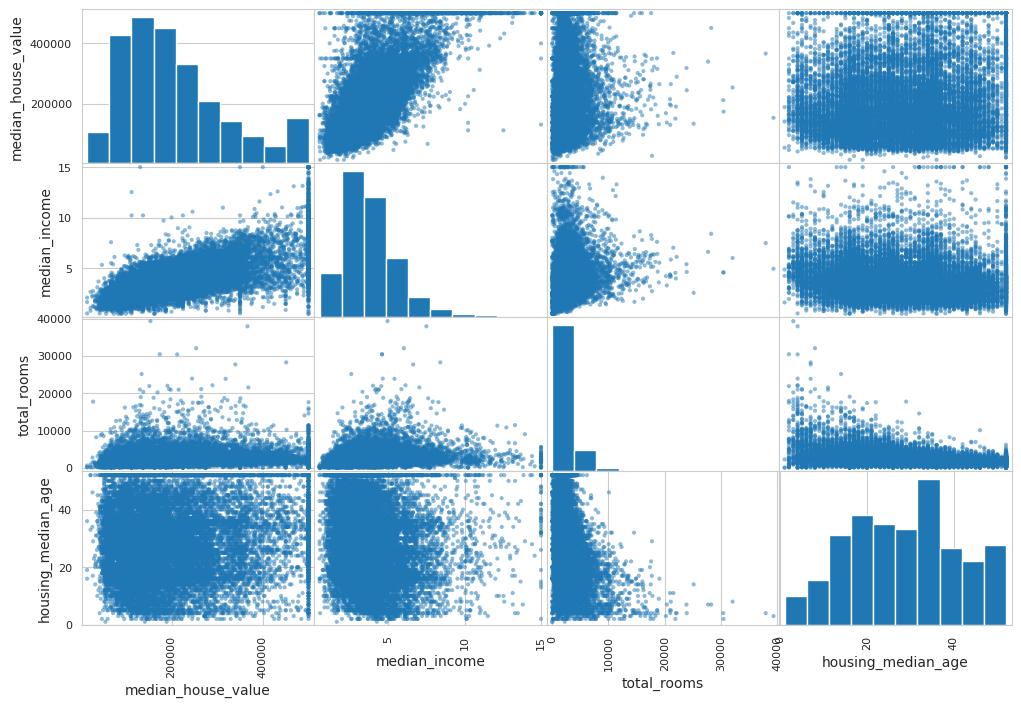

In [6]:
# Scatterplot geografis
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4,
             s=housing["population"]/100, label="population", figsize=(10,7),
             c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True) #
plt.show()

# Matriks korelasi
from pandas.plotting import scatter_matrix

attributes = ["median_house_value", "median_income", "total_rooms", "housing_median_age"]
scatter_matrix(housing[attributes], figsize=(12, 8)) #
plt.show()

In [7]:
# Memisahkan fitur dari label
housing_labels = strat_train_set["median_house_value"].copy() #
housing = strat_train_set.drop("median_house_value", axis=1) #

# Menggunakan pipeline untuk transformasi data numerik dan kategorikal
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

# Pipeline untuk atribut numerik (mengisi nilai yang hilang dan menskalakan)
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy="median")), #
    ('std_scaler', StandardScaler()), #
])

# Pipeline penuh yang menggabungkan proses untuk data numerik dan kategorikal
num_attribs = list(housing.drop("ocean_proximity", axis=1))
cat_attribs = ["ocean_proximity"]

full_pipeline = ColumnTransformer([
    ("num", num_pipeline, num_attribs),
    ("cat", OneHotEncoder(), cat_attribs), #
])

housing_prepared = full_pipeline.fit_transform(housing) #

In [8]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score

# Melatih Model Linear Regression
lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels) #

# Melatih Model Decision Tree
tree_reg = DecisionTreeRegressor()
tree_reg.fit(housing_prepared, housing_labels) #

# Melakukan Cross-Validation untuk Decision Tree
scores = cross_val_score(tree_reg, housing_prepared, housing_labels,
                         scoring="neg_mean_squared_error", cv=10) #
tree_rmse_scores = np.sqrt(-scores)
print("Decision Tree Scores:", tree_rmse_scores.mean())

# Melatih Model Random Forest
forest_reg = RandomForestRegressor()
forest_reg.fit(housing_prepared, housing_labels) #
forest_scores = cross_val_score(forest_reg, housing_prepared, housing_labels,
                                scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)
print("Random Forest Scores:", forest_rmse_scores.mean())

Decision Tree Scores: 69582.23677955967
Random Forest Scores: 49372.51686803019


In [9]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
] #

forest_reg = RandomForestRegressor()

grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                           scoring='neg_mean_squared_error',
                           return_train_score=True) #

grid_search.fit(housing_prepared, housing_labels)

# Menampilkan hyperparameter terbaik
print(grid_search.best_params_) #

# Mendapatkan model terbaik
final_model = grid_search.best_estimator_ #

{'max_features': 8, 'n_estimators': 30}


In [10]:
# Memisahkan fitur dan label dari test set
X_test = strat_test_set.drop("median_house_value", axis=1)
y_test = strat_test_set["median_house_value"].copy()

# Menjalankan pipeline transformasi (hanya transform, bukan fit_transform)
X_test_prepared = full_pipeline.transform(X_test) #

# Membuat prediksi dan menghitung RMSE final
final_predictions = final_model.predict(X_test_prepared) #
final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)
print("Final RMSE:", final_rmse) #

Final RMSE: 47806.66610290145
